### Team Classy Pie
---
# ■ Shelter Animal Outcomes, 보호소 동물들의 운명 예측하기

## Contents
> ### 1. Introduction -  프로젝트 소개
> ### 2. Datasets - 데이터 소개
> ### 3. Evaluation - 평가기준
> ### 4. EDA - 탐색적 자료 분석
> ### 5. Feature Engineering - 데이터 전처리
> ### 6. Modeling - Cross Validation - 모델링 및 검증 
> ### 7. To improve performance - 성능향상을 위한 추가사항
> ### 8. Submit Kaggle and get Score - 캐글 제출 및 결과확인
> ### 9. Conclusion - 결론


---

# 1. Introduction

    
> ### 1-1. 미국의 애완동물 현황
> - 미국 가정의 약 44%가 애완 동물을 기른다.
> - 매년 미국에서 760만 마리가 아래의 이유로 보호소에 오게 된다.    
    - 주인이 원치 않음
    - 길을 잃음
    - 학대를 당함
>
>
> - 보호소에 오는 동물들이 주인을 찾아가기도 하지만 **매년 270만 마리, 약 35%는 안락사**를 당한다.
    

> ### 1-2. 프로젝트 목표
> - 미국 텍사스의 **Austin Animal Center**는 모든 동물들에게 집을 찾아주는 것을 목표
> - 동물들의 특성 데이터를 제공해서 각 동물들의 결과를 예측
> - 입양이 덜 되는 동물들에게 에너지를 쏟아 입양률을 높이기 위한 목적

---
# 2. Datasets

- 총 3개의 파일
    
> ### 2-1. Train & Test
> - 2013.10 ~ 2016.03 기간동안 보호소에 온 강아지, 고양이의 정보
>
> - train.csv : the training set
> - test.csv : the test set
    

In [18]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [177]:
print("◆ Note : 트레인 파일은 아래와 같다.")
train.tail(3)

◆ Note : 트레인 파일은 아래와 같다.


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [178]:
print("◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.")
test.tail(3)

◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.


,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11453,11454,NaN,2014-09-29 09:00:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16:00,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40:00,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [179]:
print(train.shape)

(26729, 10)


- Train data의 컬럼
    - OutcomeType (예측해야할 target 값)
    - OutcomeSubtype (OutcomeType과 연계된 부가정보)
    - +Test data의 컬럼들
- Test data의 컬럼
    - AnimalID(중복되지않는 고유 ID)
    - Name(이름이 없는 경우가 많음)
    - DateTime(Outcome이 발생한 날짜기록)
    - AnimalType(강아지, 고양이)
    - SexuponOutcome(성별 및 중성화여부, 5가지)
    - AgeuponOutcome(동물의 나이)
    - Breed(종)
    - Color(색상)

> ### 2-2. Submission
> - sample_submission.csv : a sample submission file in the correct format
    - 모든 동물들이 떠날때 클래스별 예측 확률

--- 
# 3. Evalutaion

    Submissions are evaluated using the multi-class logarithmic loss.
    
    where N is the number of animals in the test set, M is the number of outcomes
    log is the natural logarithm
    yij is 1 if observation i is in outcome j and 0 otherwise
    pij is the predicted probability that observation i belongs to outcome j.
    


$ \Large -\frac{1}{N} \sum \sum y_{ij}log(p_{ij}) $

---
# 4. EDA & Feature Engineering

In [6]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

## 4-1. raw data Analysis & Explore

In [181]:
print('-- 데이터 간략정보 --')
train.describe().T

-- 데이터 간략정보 --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


In [182]:
print("-- 컬럼별 null의 갯수 --")
pd.DataFrame(train.isnull().sum())

-- 컬럼별 null의 갯수 --


,0
AnimalID,0
Name,7691
DateTime,0
OutcomeType,0
OutcomeSubtype,13612
AnimalType,0
SexuponOutcome,1
AgeuponOutcome,18
Breed,0
Color,0


In [183]:
print('-- 중복자료 및 unique --')
train.describe().T

-- 중복자료 및 unique --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


-- OutcomeType의 내용 --


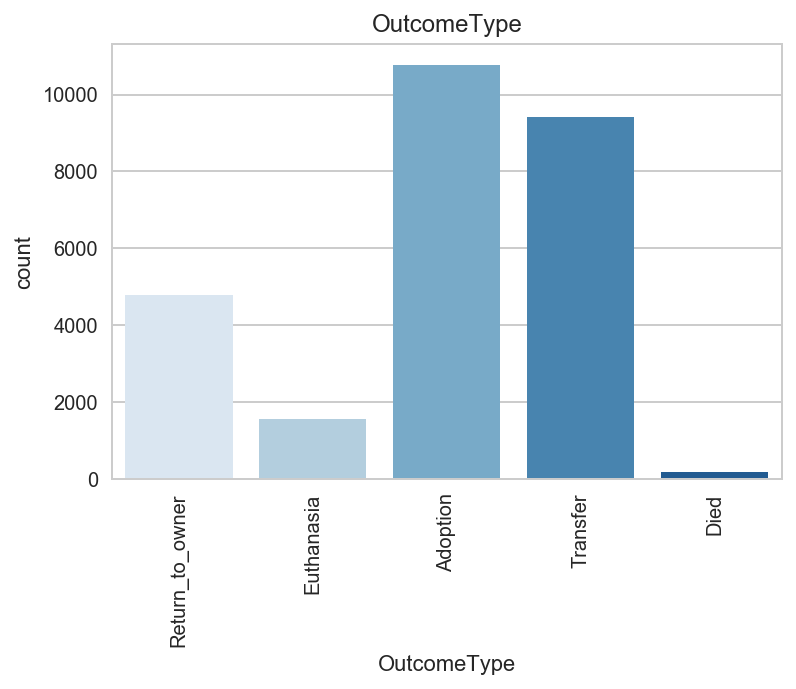

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [184]:
print("-- OutcomeType의 내용 --")
sns.countplot(x=train["OutcomeType"], data=train , palette="Blues")
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show()
train["OutcomeType"].value_counts()

In [185]:
print("-- OutcomeSubtype의 내용 --")
train.groupby("OutcomeSubtype").size().reset_index(name='count').sort_values('count', ascending=False)

-- OutcomeSubtype의 내용 --


,OutcomeSubtype,count
12,Partner,7816
6,Foster,1800
14,SCRP,1599
15,Suffering,1002
0,Aggressive,320
11,Offsite,165
8,In Kennel,114
3,Behavior,86
13,Rabies Risk,74
10,Medical,66


In [186]:
print("-- AnimalType의 내용 --")
train.groupby("AnimalType").size().reset_index(name='count').sort_values('count',ascending=False)

-- AnimalType의 내용 --


,AnimalType,count
1,Dog,15595
0,Cat,11134


In [187]:
print("-- SexuponOutcome의 내용 --")
train.groupby("SexuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False)

-- SexuponOutcome의 내용 --


,SexuponOutcome,count
2,Neutered Male,9779
3,Spayed Female,8820
1,Intact Male,3525
0,Intact Female,3511
4,Unknown,1093


In [188]:
print("-- AgeuponOutcome의 내용 --")
print("     - ※10개만 표시하고 중략")
train.groupby("AgeuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False).head(10)

-- AgeuponOutcome의 내용 --
     - ※10개만 표시하고 중략


,AgeuponOutcome,count
5,1 year,3969
21,2 years,3742
19,2 months,3397
26,3 years,1823
2,1 month,1281
24,3 months,1277
30,4 years,1071
34,5 years,992
28,4 months,888
37,6 years,670


In [189]:
print("-- Breed의 내용 --")
print("     - 15개 항목만 표시하고 중략")
train.groupby("Breed").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Breed의 내용 --
     - 15개 항목만 표시하고 중략


,Breed,count
640,Domestic Shorthair Mix,8810
1066,Pit Bull Mix,1906
450,Chihuahua Shorthair Mix,1766
847,Labrador Retriever Mix,1363
637,Domestic Medium Hair Mix,839
696,German Shepherd Mix,575
632,Domestic Longhair Mix,520
1251,Siamese Mix,389
74,Australian Cattle Dog Mix,367
559,Dachshund Mix,318


In [190]:
print("-- Color의 내용 --")
print("    - 15개 항목만 표시하고 중략")
train.groupby("Color").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Color의 내용 --
    - 15개 항목만 표시하고 중략


,Color,count
38,Black/White,2824
5,Black,2292
104,Brown Tabby,1635
111,Brown Tabby/White,940
318,White,931
130,Brown/White,884
216,Orange Tabby,841
289,Tan/White,773
307,Tricolor,752
86,Blue/White,702


### NaN값 처리

In [368]:
# 나이정보가 없는 경우 10여 종류
train[train["AgeuponOutcome"].isnull() == True]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
2480,A720674,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White
2912,A720973,NaN,2016-02-18 19:07:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Gray Tabby
3766,A720820,NaN,2016-02-16 18:55:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby
3875,A721076,NaN,2016-02-20 16:37:00,Euthanasia,Suffering,Dog,Intact Male,NaN,Toy Poodle Mix,White
4498,A720422,NaN,2016-02-09 19:43:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby
5137,A720697,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Spayed Female,NaN,Domestic Shorthair Mix,Black
5691,A720640,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black Tabby/White
7005,A720636,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black
8420,A720701,NaN,2016-02-16 10:16:00,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White
17464,A720782,NaN,2016-02-16 18:55:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Torbie


In [20]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
train["OutcomeSubtype"] = train["OutcomeSubtype"].fillna("NoStatus")
train["SexuponOutcome"] = train["SexuponOutcome"].fillna("Unknown")
train["AgeuponOutcome"] = train["AgeuponOutcome"].fillna("-1 nodata")

## 4-2. Feature Engineering & Analysis

### - 비정형 데이터 --> 반정형화(정리) --> 정형화(OHE,Categorizing)

In [68]:
# 전처리함수(수정가능)---------------
import datetime as dt


def preprocessShelter(df_raw):
    df = df_raw.copy()
    # Name --> Isname------------------------------------------
    df['Name'].fillna('Unknown', inplace=True)

    # 이름이 있으면 Has_name, 이름이 없으면 Unknown------------
    name = []
    for i in df['Name']:
        if i == 'Unknown':
            name.append('Unknown_name')
        else:
            name.append('Has_name')
    df['Name'] = name
    
    
    # color정리 - black, white, brown, others로 나눔
    color = []
    for i in df['Color']:
        if i[:5] == 'Black':
            color.append('Black')
        elif i[:5] == 'White':
            color.append('White')
        elif i[:5] == 'Brown':
            color.append('Brown')
        else:
            color.append('C_Others')
    df['Color'] = color    
    
    #--------------------------------------------1차 추가되는 컬럼정리(나이, 성별)
    
    df["sex_intact"] = (df["SexuponOutcome"].str.slice(0,6) == "Intact").astype(int)
    df["sex_unknown"] = (df["SexuponOutcome"] == "Unknown").astype(int)
    df["sex_mf"] = (df["SexuponOutcome"].str.split(' ', n=2, expand=True)[1] == "Male").astype(int)
    df.sex_mf[df["sex_unknown"]==1] = 2
    df.sex_intact[df["sex_unknown"]==1] = 2
    
    # 나이데이터 재정리 (Agenbr=나이의숫자만, Age_tscale=(day,week,month,year), Age_yscale=동물의 연생, 
    df["Age_nbr"] = df["AgeuponOutcome"].str.slice(0,2).astype(int) # 0인값의경우 해당 동물의 나이정보가 없는것으로 추정한다
    df["Age_tscale"] = df["AgeuponOutcome"].str.split(" ", n=2, expand=True)[1] # 띄어쓰기 된 뒷문장 가져오기
    df["Age_tscale"] = df["Age_tscale"].replace("s","",regex=True) # 문자 s를 삭제
    df["Age_yscale"] = df["Age_tscale"].replace(["day","week","month"],"under_year")
    df["Age_ynbr"] = df["Age_nbr"].copy()
    df.Age_ynbr[df["Age_yscale"]=="under_year"] = 0
    
    df["Age_daily_scale"] = 0
    df.Age_daily_scale[df['Age_tscale']=="day"] = 1
    df.Age_daily_scale[df['Age_tscale']=="week"] = 7
    df.Age_daily_scale[df['Age_tscale']=="month"] = 30
    df.Age_daily_scale[df['Age_tscale']=="year"] = 365
    df["Age_daily_scale"] = df["Age_daily_scale"]*df["Age_nbr"]

    df["Age_code"] = 'Y'
    
    # Breed 정제-1차
    df["Breed_Do"] = 0
    df["Breed_Mx"] = 0
    df["Breed_Lh"] = 0
    df["Breed_Mh"] = 0
    df["Breed_Sh"] = 0
    df["Breed_dogM"] = 0
    df.Breed_Do[df['Breed'].str.contains("Domestic", regex=True)] = 1
    df.Breed_Mx[df['Breed'].str.contains("Mix", regex=True)] = 1
    df.Breed_Lh[df['Breed'].str.contains("Longhair", regex=True)] = 1
    df.Breed_Sh[df['Breed'].str.contains("Shorthair", regex=True)] = 1
    df.Breed_Mh[df['Breed'].str.contains("MediumHair", regex=True)] = 1
    df.Breed_dogM[df['Breed'].str.contains("/", regex=True)] = 1
    df["Breed_extra"] = df["Breed"].replace(["Domestic","Mix"," ","Shorthair","Longhair","MediumHair",""],"",regex=True) # 문자 s를 삭제
    
    

    # 시간데이터 정제
    temp = pd.to_datetime(df['DateTime'])

    df["Time_year"] = temp.dt.strftime("%Y").astype(int)
    df["Time_month"] = temp.dt.strftime("%m").astype(int)
    df["Time_DOW"] = temp.dt.dayofweek.astype(int)
    df["Time_day"] = temp.dt.strftime("%d").astype(int)
    df["Time_hour"] = temp.dt.strftime("%H").astype(int)
    
    
    # 미 텍사스주 공휴일
    
    df["Holidays"] = 0
    df.Holidays[(df['Time_month']==1)&(df['Time_day']==19)]=1
    df.Holidays[(df['Time_month']==3)&(df['Time_day']==2)]=2
    df.Holidays[(df['Time_month']==4)&(df['Time_day']==21)]=3
    df.Holidays[(df['Time_month']==5)&(df['Time_day']==10)]=4
    df.Holidays[(df['Time_month']==6)&(df['Time_day']==19)]=5
    df.Holidays[(df['Time_month']==6)&(df['Time_day']>=18)&(df['Time_day']<=22)]=6
    df.Holidays[(df['Time_month']==8)&(df['Time_day']==27)]=7
    df.Holidays[(df['Time_month']==11)&(df['Time_day']==11)]=8
    df.Holidays[(df['Time_month']==11)&(df['Time_day']>=25)&(df['Time_day']<=27)]=9
    df.Holidays[(df['Time_month']==12)&(df['Time_day']>=23)&(df['Time_day']<=27)]=10
    
    return df


#--------아래는 All카테고라이저, All원핫인코더 함수-------

from sklearn.preprocessing import LabelEncoder
def allCategorizer(df, columns=[]):

    print("Categorizing start... using ", columns)
    
    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
    
    temp = df[col_name].copy()
    
    for i in range(col_num):
        le = LabelEncoder()
        y = temp[col_name[i]]
        le.fit(y)
        temp[col_name[i]] = le.transform(y)
        print(i,", ",end="")
    print("Complete!")
    return temp        
        
def allOneHotEncoder(df, columns=[]):
    print("One_Hot_Encoding start... using ", columns)

    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
        
    for i in range(col_num):
        temp = pd.get_dummies(df[col_name[i]])
        if i == 0 : 
            onehot_df = temp.copy()
            print(i,", ",end="")
        else : 
            onehot_df = pd.concat([onehot_df,temp], axis=1)
            print(i,", ",end="")
    print("Complete!")
    return onehot_df



# 전처리된 데이터프레임 설정 --> df_train -------------------

df_train = preprocessShelter(train)

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [29]:
print(df_train.columns)
df_train.describe().T


Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_nbr', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_code', 'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
sex_intact,26729.0,0.345093,0.554864,0.0,0.0,0.0,1.0,2.0
sex_unknown,26729.0,0.040929,0.198130,0.0,0.0,0.0,0.0,1.0
sex_mf,26729.0,0.579595,0.570557,0.0,0.0,1.0,1.0,2.0
Age_nbr,26729.0,3.625164,2.929210,-1.0,2.0,2.0,5.0,20.0
Age_ynbr,26729.0,2.059673,3.038562,-1.0,0.0,1.0,3.0,20.0
Breed_Do,26729.0,0.389165,0.487570,0.0,0.0,0.0,1.0,1.0
Breed_Mx,26729.0,0.834225,0.371885,0.0,1.0,1.0,1.0,1.0
Breed_Lh,26729.0,0.029780,0.169984,0.0,0.0,0.0,0.0,1.0
Breed_Mh,26729.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Breed_Sh,26729.0,0.426952,0.494644,0.0,0.0,0.0,1.0,1.0


In [97]:
# 전처리 2단계 -- 카테고리화 및 One Hot Encoding
cols= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']
cols2=['Name', 'AnimalType', 'Color', 
       'sex_intact', 'sex_unknown', 'sex_mf',
       'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_daily_scale',
       'Breed_Do', 'Breed_Mx', 'Breed_Mh', 'Breed_Lh', 'Breed_Sh', 'Breed_dogM',
       'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays']
df_OHE = allOneHotEncoder(df_train,cols2)
df_Ctg = allCategorizer(df_train,cols2)
# temp.head(20)
# df_train[cols]

One_Hot_Encoding start... using  ['Name', 'AnimalType', 'Color', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_daily_scale', 'Breed_Do', 'Breed_Mx', 'Breed_Mh', 'Breed_Lh', 'Breed_Sh', 'Breed_dogM', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , Complete!
Categorizing start... using  ['Name', 'AnimalType', 'Color', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_daily_scale', 'Breed_Do', 'Breed_Mx', 'Breed_Mh', 'Breed_Lh', 'Breed_Sh', 'Breed_dogM', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , Complete!


### - Name & OutcomeType

- `Name` column preprocessing
    - 동물의 이름
    - 동물이 이름을 가지고 있으면 Has_name, 이름을 가지지 않으면 Unknown


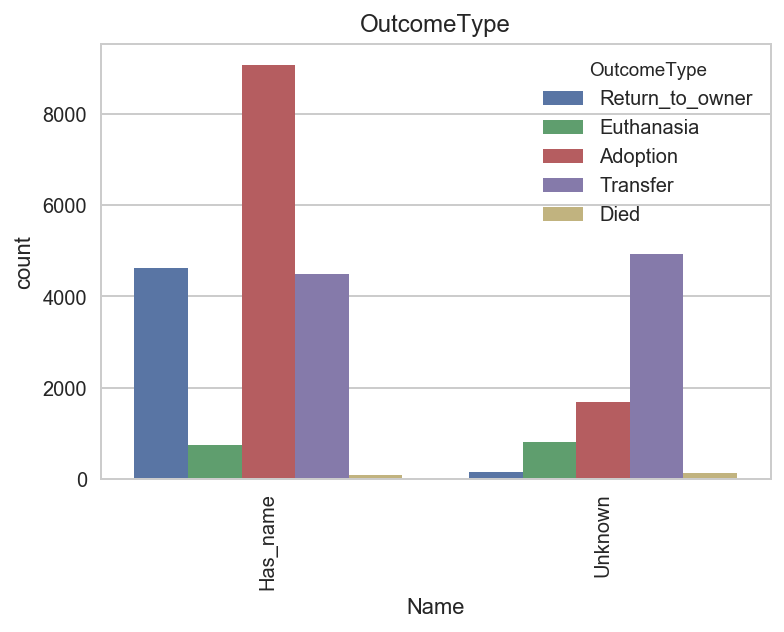

In [158]:
# 이름이 있는 경우 어덥션 높고 이름 없는 경우 transfer 높다.
sns.countplot(x="Name", data=df_train , hue ='OutcomeType')
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show() 

### - AnimalType & OutcomeType

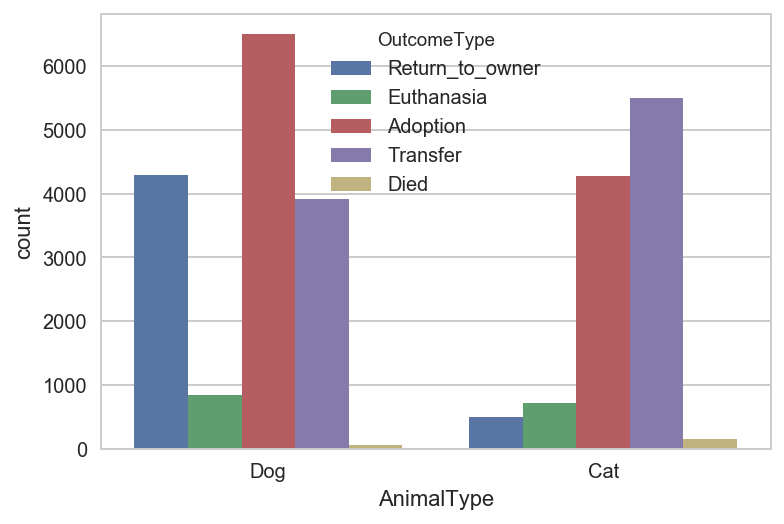

In [159]:
sns.countplot(x='AnimalType',data=df_train, hue='OutcomeType')
plt.show()

### - SexuponOutcome & OutcomeType

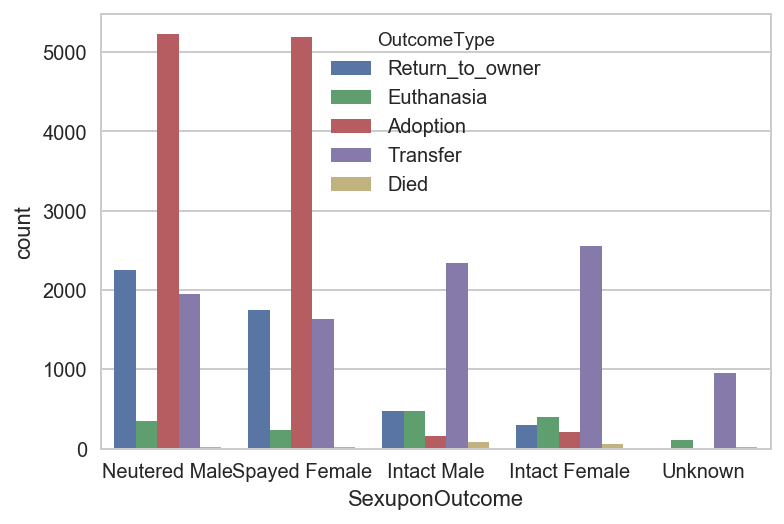

In [160]:
# 중성화 된 동물들의 어덥션이 높고 중성화 되지 않은 동물들이 transfer 된 경우가 많음
sns.countplot(x='SexuponOutcome',data=train, hue='OutcomeType')
plt.show()

### - AgeuponOutcome & OutcomeType

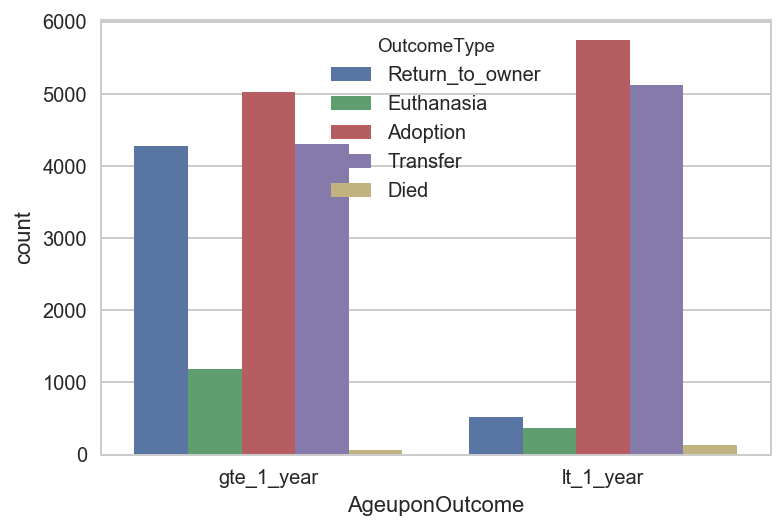

In [163]:
# 1살 이상의 동물들이 주인에게 돌아가는 경우가 많다.
sns.countplot(x='AgeuponOutcome',data=df_train, hue='OutcomeType')
plt.show()

동물의 나이별(년) 개체수 통계


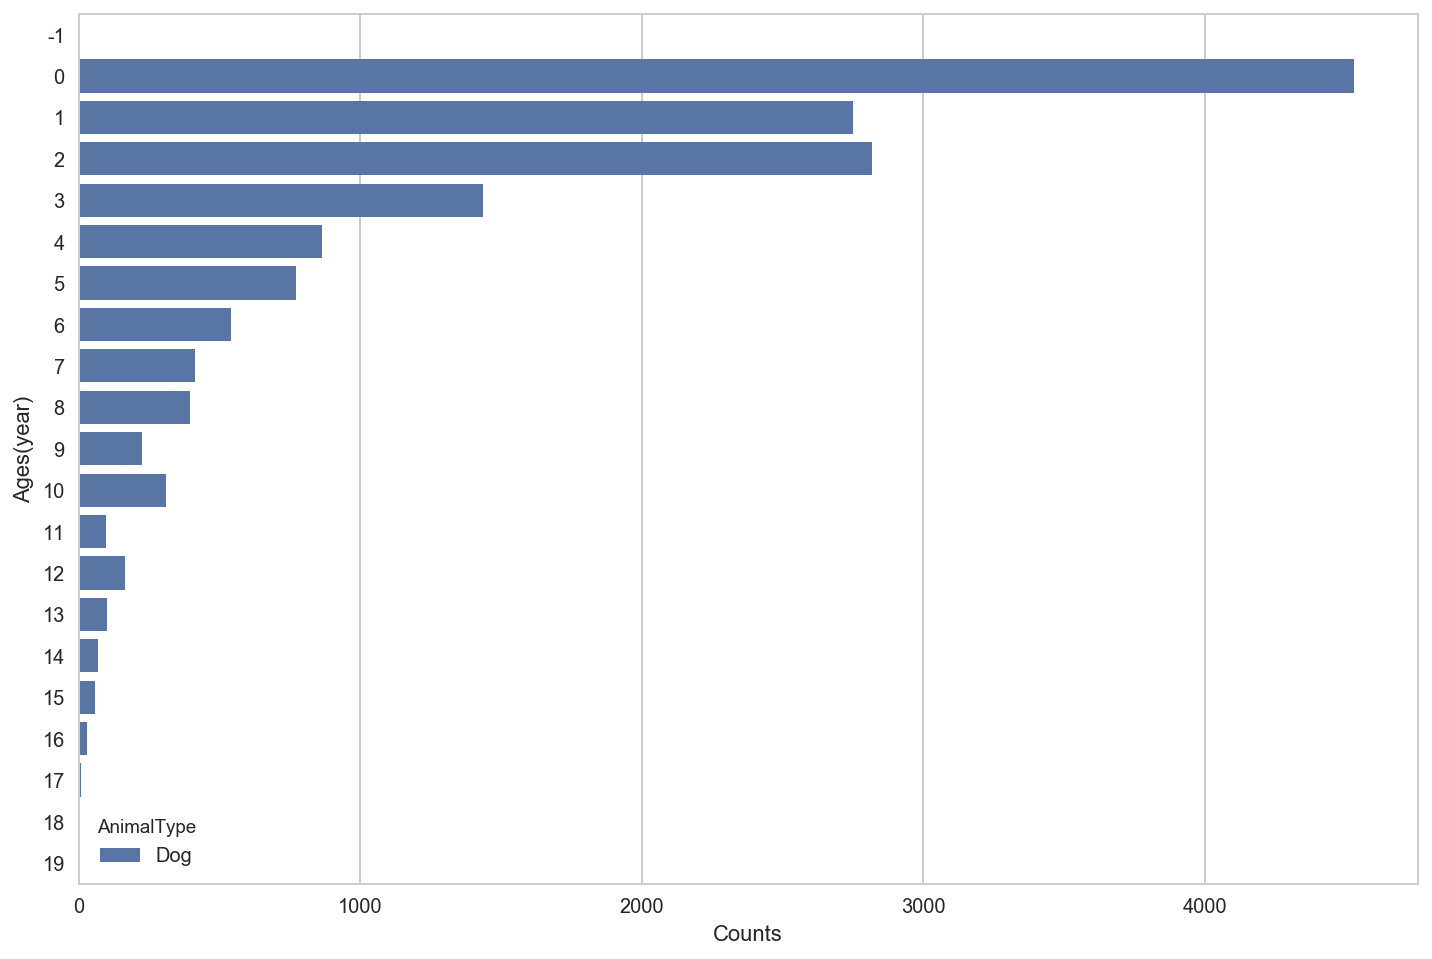

In [470]:
# 위 그래프 정제결과1 : 동
sorted_df = df_train.groupby(["Age_ynbr","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_ynbr'] = pd.Categorical(sorted_df['Age_ynbr'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_ynbr", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("동물의 나이별(년) 개체수 통계")

### - Color & OutcomeType

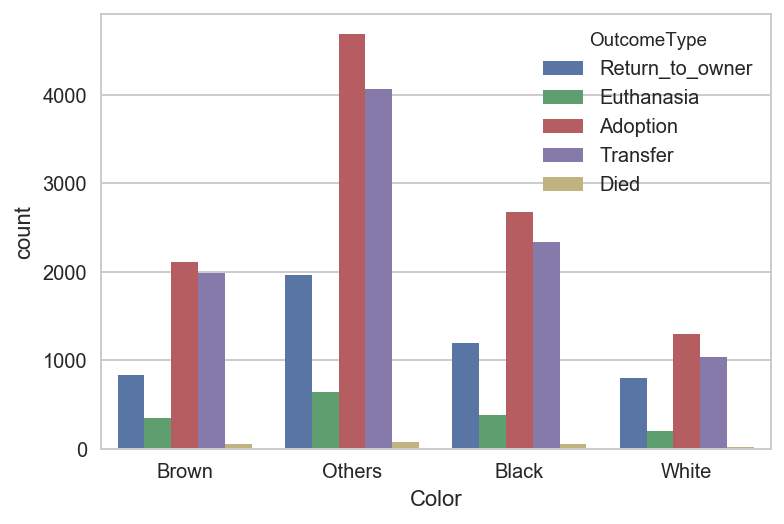

In [67]:
# 색상별로 큰 분포의 차이를 보이진 않아 추후 다른 아이디어를 이용해 볼 예정
sns.countplot(x='Color',data=train, hue='OutcomeType')
plt.show()

동물의 처리결과별 - 특징 통계


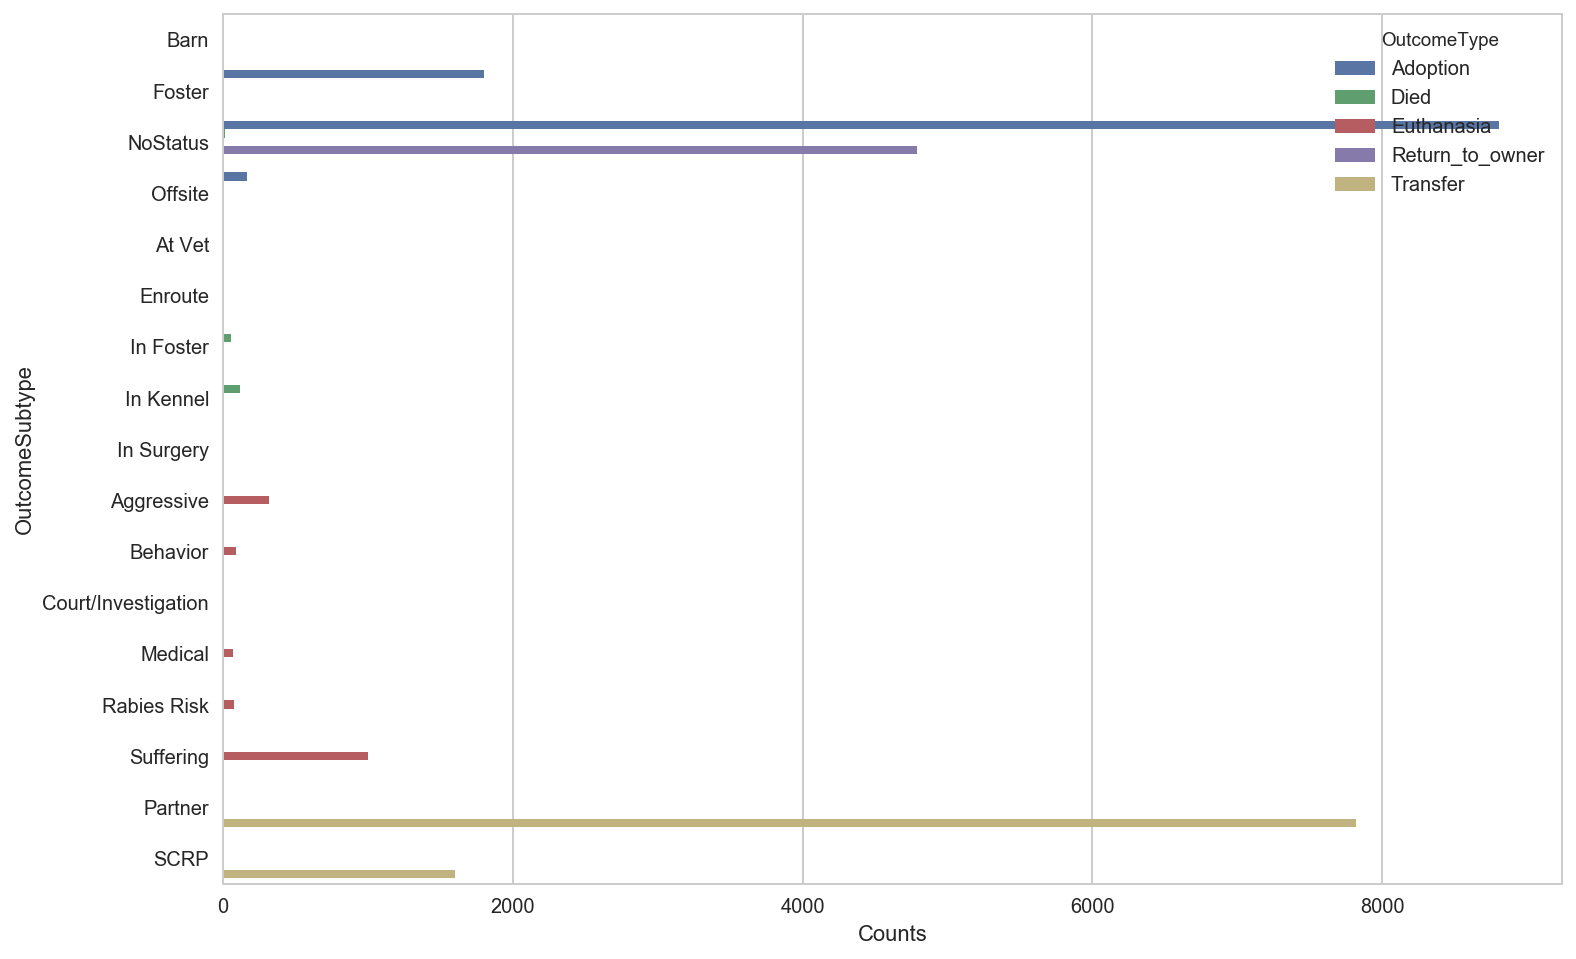

In [16]:
sorted_df = df_train.groupby(["OutcomeType","OutcomeSubtype"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeSubtype", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeSubtype')
print("동물의 처리결과별 - 특징 통계")

### 5-6. Breed

- 개, 고양이의 종류

In [24]:
extra = df_train.groupby('Breed_extra').size().reset_index(name="count").sort_values("count",ascending=False)
extra.head(10)

,Breed_extra,count
0,,9496
396,Chihuahua,2002
941,PitBull,1972
739,LabradorRetriever,1432
840,MediumHair,881
604,GermanShepherd,652
1107,Siamese,413
490,Dachshund,405
71,AustralianCattleDog,392
282,Boxer,275


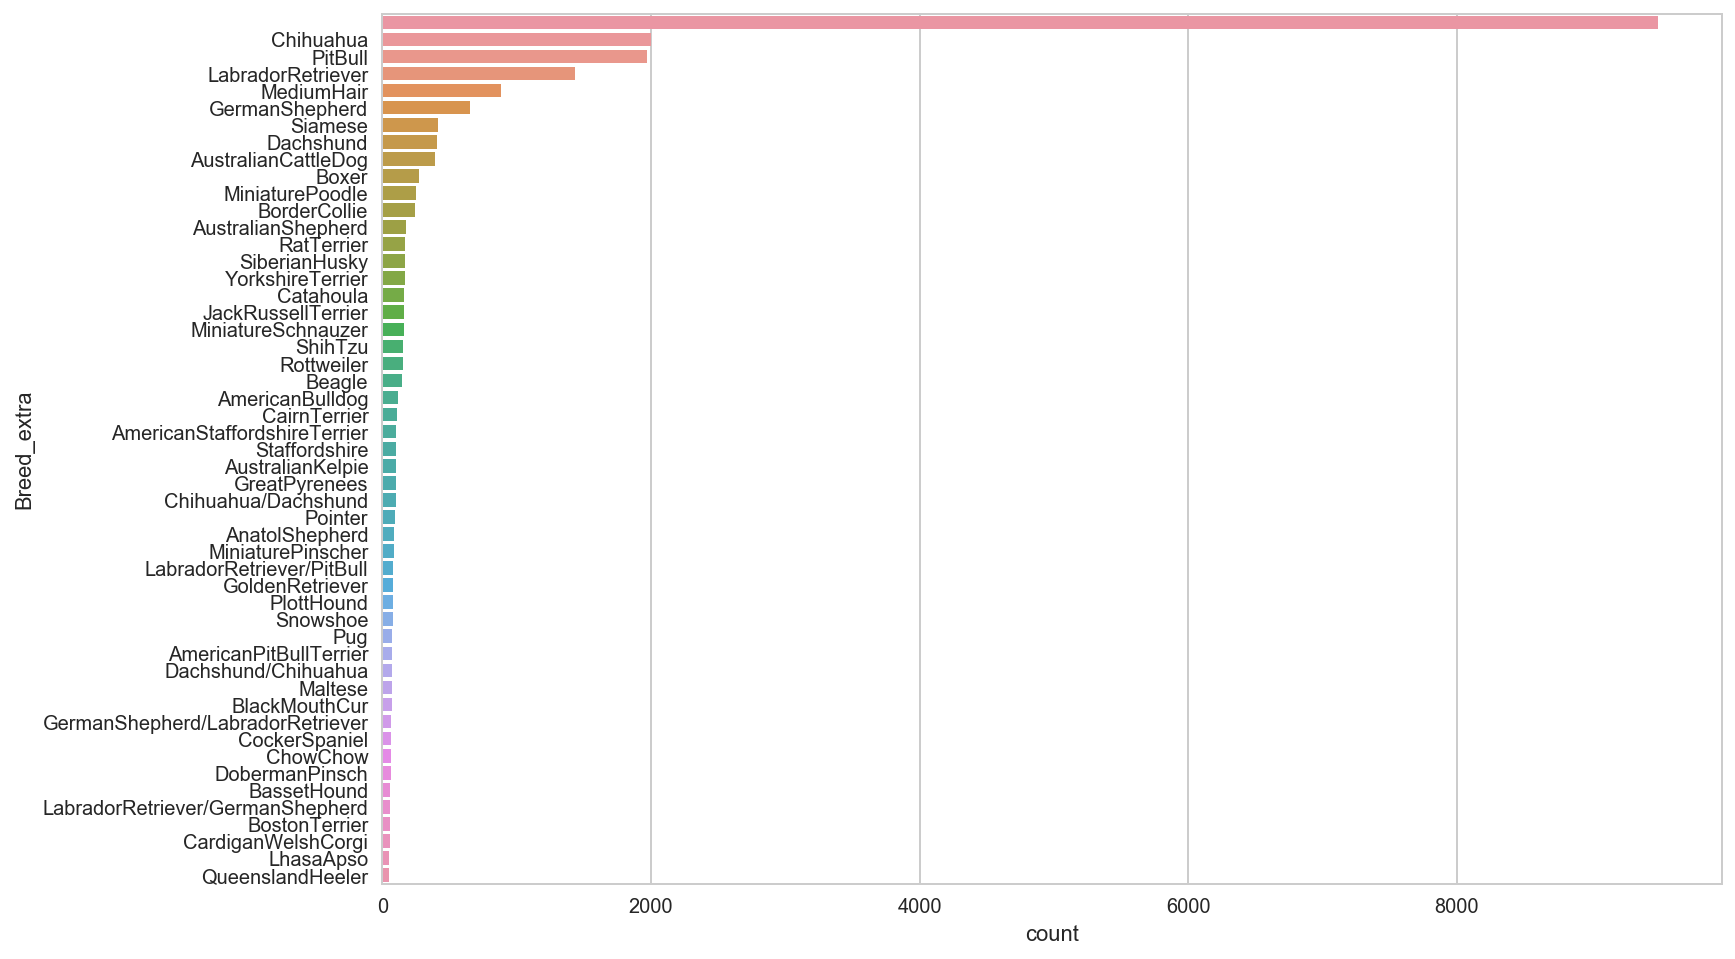

In [25]:
plt.figure(figsize=(12,8))
sns.barplot(x="count",y="Breed_extra",data=extra[extra["count"]>50])

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.]),
 <a list of 9 Text xticklabel objects>)

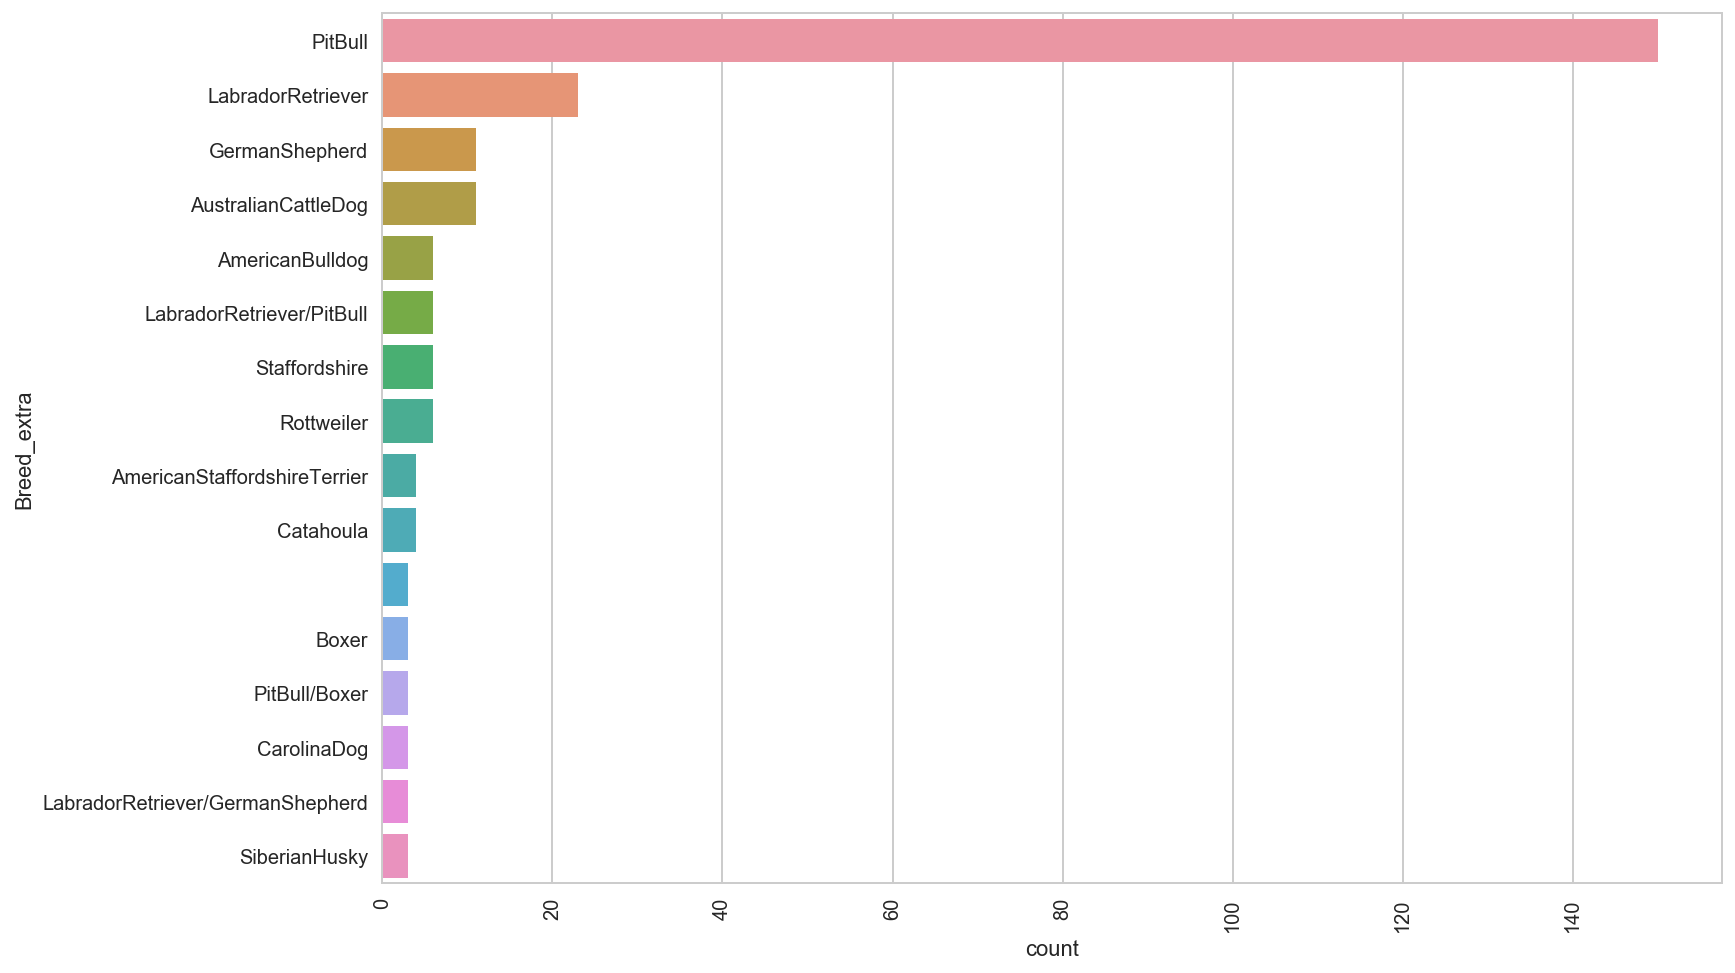

In [72]:
temp = df_train[df_train["OutcomeSubtype"]=="Aggressive"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>2])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

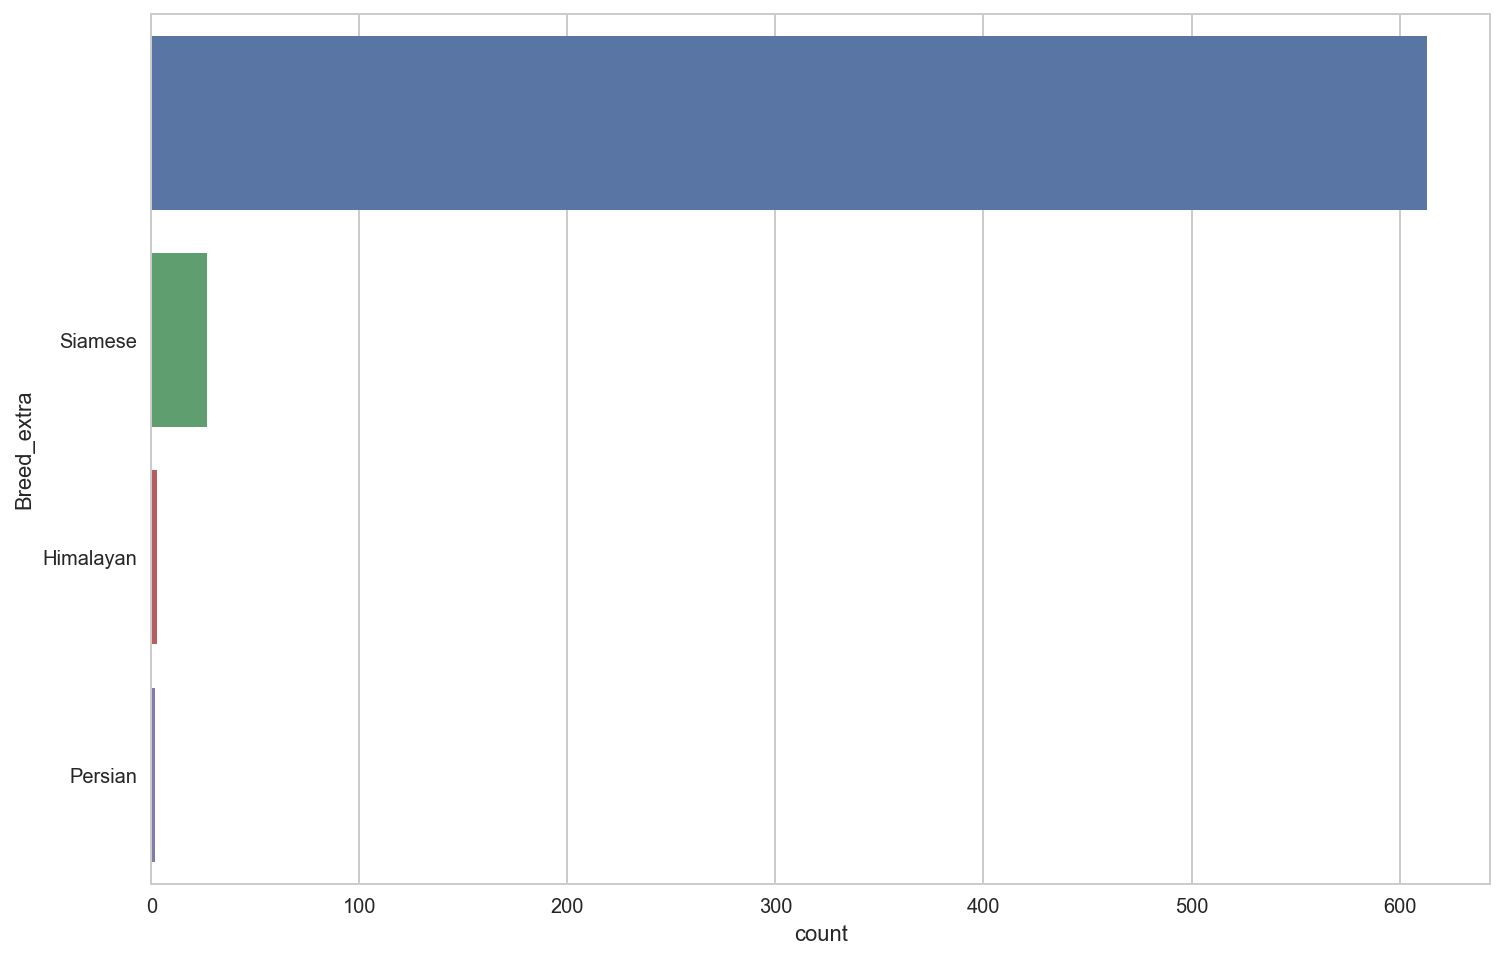

In [30]:
temp = df_train[df_train["OutcomeSubtype"]=="Suffering"]
temp = temp[temp["AnimalType"]=="Cat"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>1])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

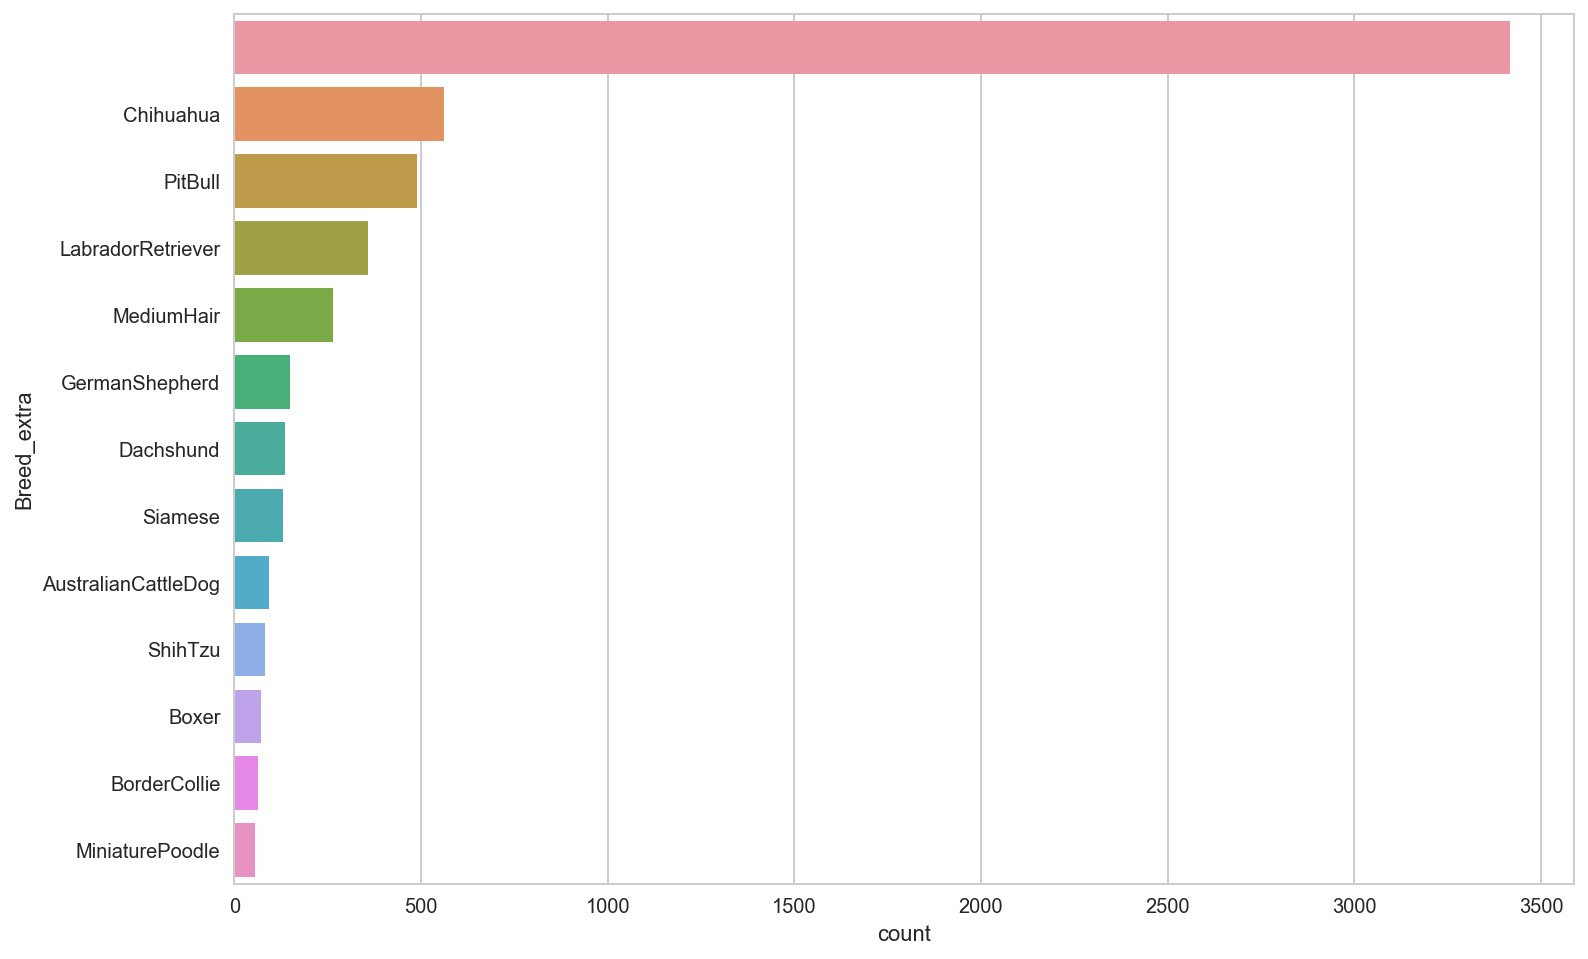

In [17]:
temp = df_train[df_train["OutcomeSubtype"]=="Partner"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>50])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

[]

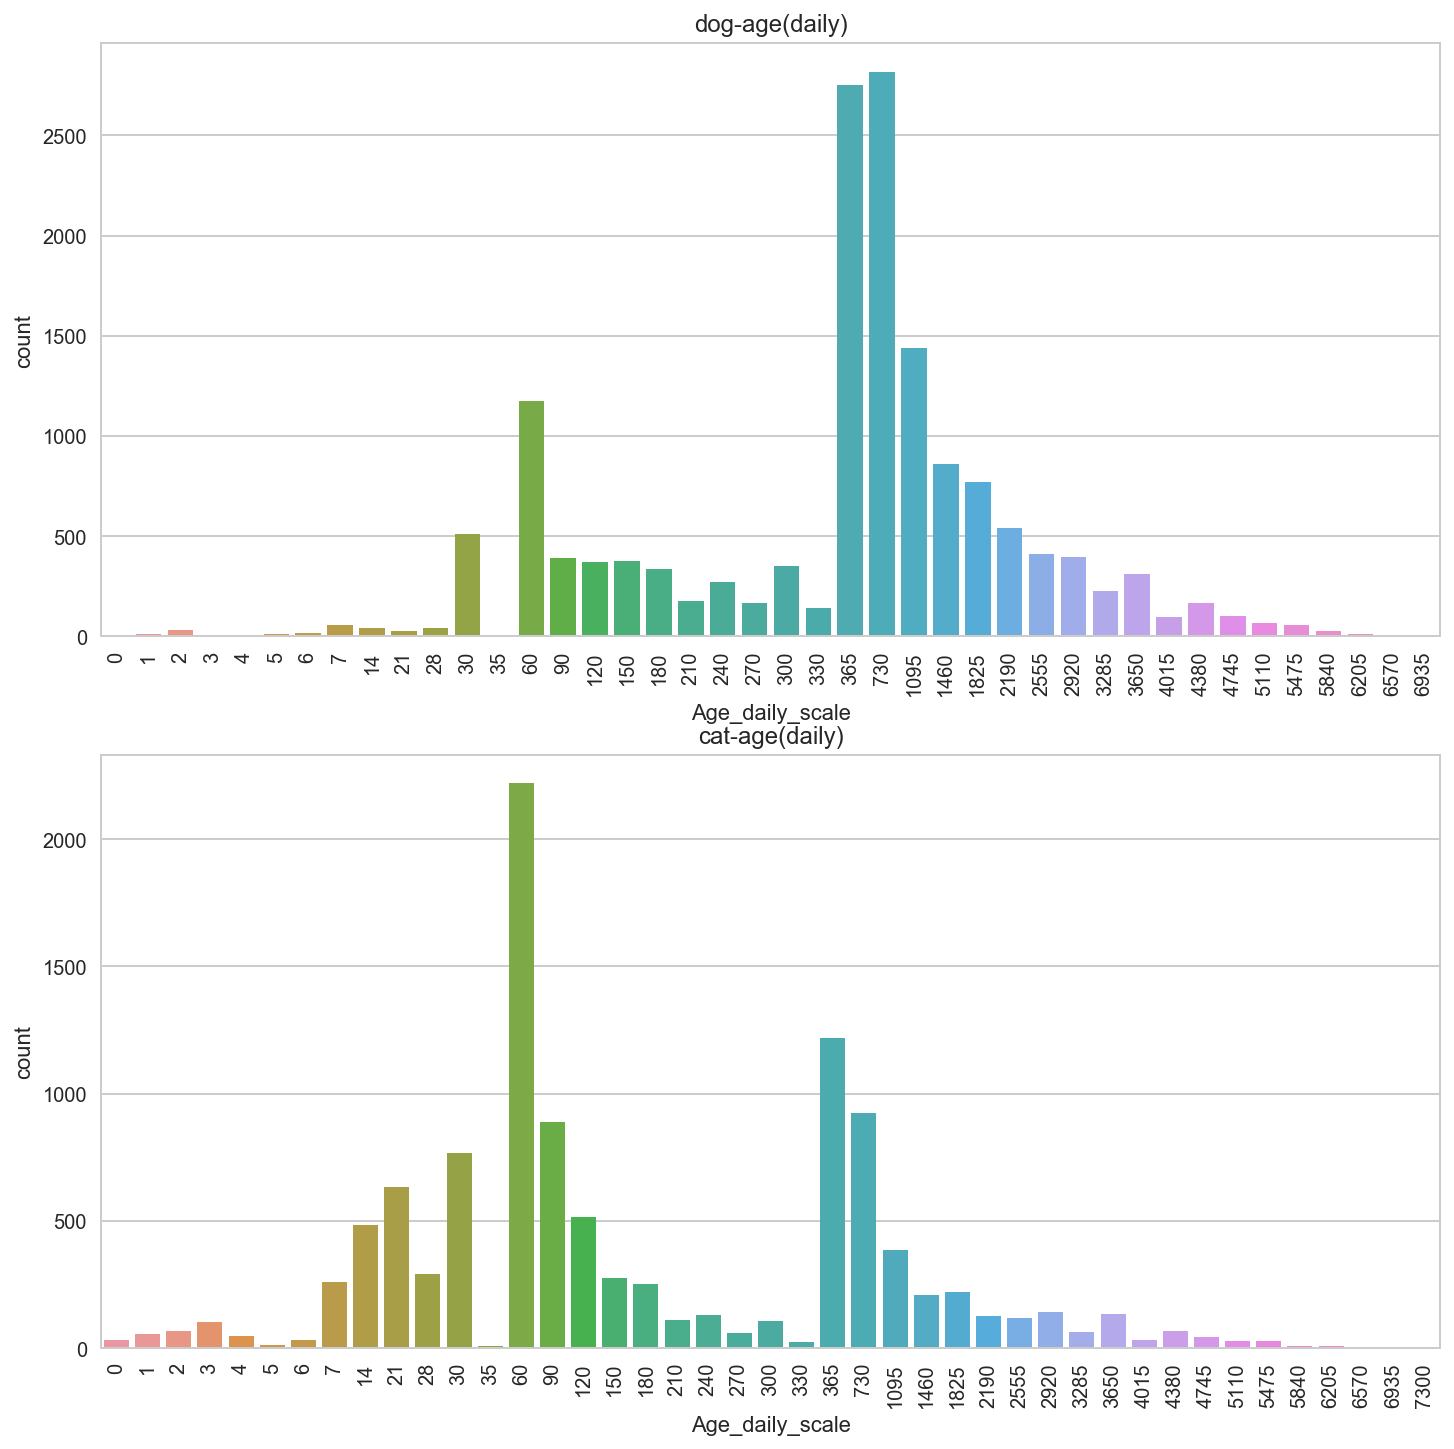

In [82]:
temp1 = df_train[df_train["AnimalType"]=="Dog"]
temp1 = temp1.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

temp2 = df_train[df_train["AnimalType"]=="Cat"]
temp2 = temp2.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

plt.figure(figsize=(12,12))
plt.subplot(211)
sns.barplot(data=temp1, x='Age_daily_scale',y='count').set_title("dog-age(daily)")
plt.xticks(rotation="vertical")
plt.subplot(212)
sns.barplot(data=temp2, x='Age_daily_scale',y='count').set_title("cat-age(daily)")
plt.xticks(rotation="vertical")
plt.plot()

## 6. Classification Modeling - Cross Validation
0. 나이브 베이지안
1. 의사결정나무
2. 랜덤포레스트
3. XGBoost
4. 앙상블 = 랜덤포레스트 + XGBoost
5. 신경망 - keras

### 분석용 변수 설정

In [90]:
#사전조건 설정 (고양이 or 개)
train_if = train.copy()
# train_if = train[train["AnimalType"]=="Cat"].copy()
# train_if = train[train["AnimalType"]=="Dog"].copy()

In [91]:
# y값 카테고리화
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = train_if['OutcomeType']
le.fit(y)
y= le.transform(y)
y

array([3, 2, 0, ..., 0, 4, 4], dtype=int64)

In [92]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

In [98]:
#분석할 컬럼들
cols= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']
cols2=['Name', 'Color', 'Animaltype', 'sex_intact', 'sex_unknown', 'sex_mf',
       'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_daily_scale',
       'Breed_Do', 'Breed_Mx', 'Breed_Mh', 'Breed_Lh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra',
        'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays']

# 카테고리화 및 OneHotEncoding
df_train = preprocessShelter(train_if)

df_OHE = allOneHotEncoder(df_train,cols2)
df_Ctg = allCategorizer(df_train,cols2)



C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

One_Hot_Encoding start... using  ['Name', 'Color', 'Animaltype', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_daily_scale', 'Breed_Do', 'Breed_Mx', 'Breed_Mh', 'Breed_Lh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays']
0 , 1 , 

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 'Animaltype'

In [99]:
df_Ctg.columns

Index(['Name', 'AnimalType', 'Color', 'sex_intact', 'sex_unknown', 'sex_mf', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_daily_scale', 'Breed_Do', 'Breed_Mx', 'Breed_Mh', 'Breed_Lh', 'Breed_Sh', 'Breed_dogM', 'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays'], dtype='object')

### 의사결정나무 + cv

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
model testing...
Tree Model1: Mean score: 0.608 --- acuraccy score : 0.608
Tree Model2: Mean score: 0.608 --- acuraccy score : 0.608
Tree Model3: Mean score: 0.608 --- acuraccy score : 0.608
Tree Model4: Mean score: 0.618 --- acuraccy score : 0.621
Tree Model5: Mean score: 0.632 --- acuraccy score : 0.635
Tree Model6: Mean score: 0.650 --- acuraccy score : 0.660
Tree Model7: Mean score: 0.664 --- acuraccy score : 0.671
Tree Model8: Mean score: 0.671 --- acuraccy score : 0.681
Tree Model9: Mean score: 0.669 --- acuraccy score : 0.690
Tree Model10: Mean score: 0.668 --- acuraccy score : 0.705
Tree Model11: Mean score: 0.662 --- acuraccy score : 0.721
Tree Model12: Mean score: 0.656 --- acuraccy score : 0.741
Tree Model13: Mean score: 0.651 --- acuraccy score : 0.768
Tree Model14: Mean score: 0.643 --- acuraccy score : 0.794
Tree Model15: Mean score: 0.633 --- acuraccy score : 0.820


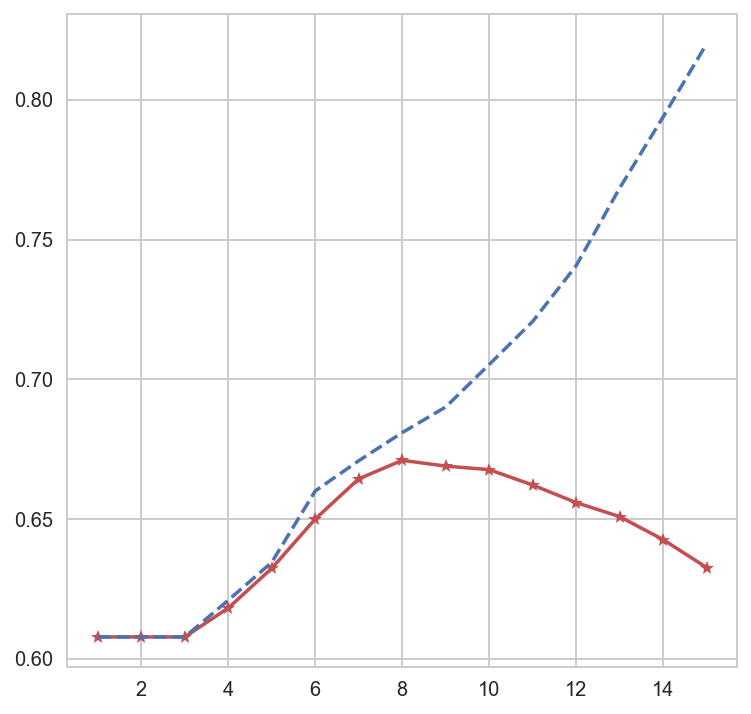

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
tree_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,16):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0).fit(df_Ctg,y)
    print(",",i,end="")
    tree_ls.append(tree)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(tree_ls):
    scores = cross_val_score(model, df_Ctg, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_Ctg))
    print(("Tree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

In [101]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
treeA = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0).fit(df_Ctg,y)

from sklearn.metrics import *
print("- Accuracy_Score : ", accuracy_score(y,treeA.predict(df_Ctg)))
print("- Confusion_Matrix \n",confusion_matrix(y, treeA.predict(df_Ctg)))
print(classification_report(y, treeA.predict(df_Ctg), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))

- Accuracy_Score :  0.680945789218
- Confusion_Matrix 
 [[9090    3   19 1074  583]
 [  23   30    9    8  127]
 [ 268    4  363  249  671]
 [2013    0   26 2025  722]
 [1886    6  153  684 6693]]
                 precision    recall  f1-score   support

       Adoption       0.68      0.84      0.76     10769
           Died       0.70      0.15      0.25       197
     Euthanasia       0.64      0.23      0.34      1555
Return_to_owner       0.50      0.42      0.46      4786
       Transfer       0.76      0.71      0.73      9422

    avg / total       0.68      0.68      0.67     26729



array([ 0.10468346,  0.04899299,  0.00092982,  0.40126441,  0.        ,
        0.00233537,  0.        ,  0.        ,  0.01383906,  0.23730681,
        0.00399772,  0.0009717 ,  0.        ,  0.00052206,  0.00525022,
        0.00052934,  0.010275  ,  0.0100297 ,  0.02789668,  0.00793383,
        0.12102525,  0.0022166 ])

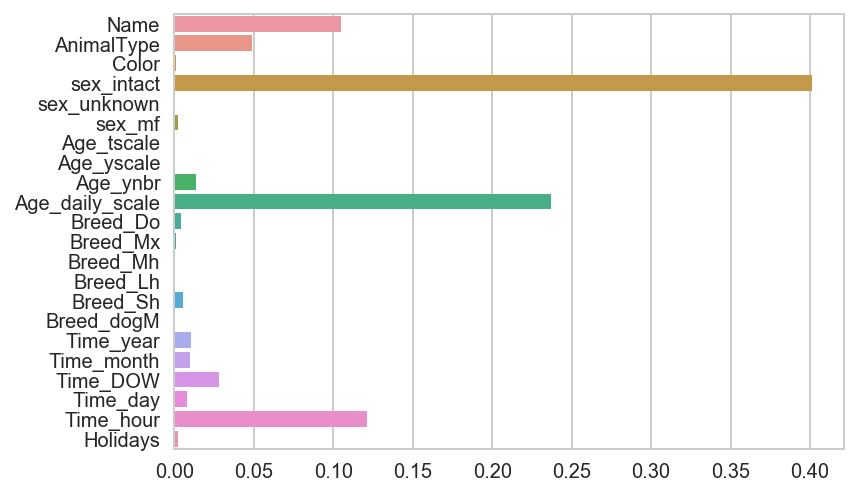

In [102]:
# 피쳐 중요도
importance = treeA.feature_importances_
sns.barplot(y=df_Ctg.columns, x=importance)
importance

### 랜덤포레스트 + cv

RFmodel creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
model testing...
RandomForest Model1: Mean score: 0.603 --- acuraccy score : 0.604
RandomForest Model2: Mean score: 0.614 --- acuraccy score : 0.614
RandomForest Model3: Mean score: 0.615 --- acuraccy score : 0.615
RandomForest Model4: Mean score: 0.635 --- acuraccy score : 0.638
RandomForest Model5: Mean score: 0.657 --- acuraccy score : 0.658
RandomForest Model6: Mean score: 0.662 --- acuraccy score : 0.664
RandomForest Model7: Mean score: 0.664 --- acuraccy score : 0.670
RandomForest Model8: Mean score: 0.669 --- acuraccy score : 0.678
RandomForest Model9: Mean score: 0.670 --- acuraccy score : 0.689
RandomForest Model10: Mean score: 0.676 --- acuraccy score : 0.701
RandomForest Model11: Mean score: 0.680 --- acuraccy score : 0.720
RandomForest Model12: Mean score: 0.681 --- acuraccy score : 0.746
RandomForest Model13: Mean score: 0.683 --- acuraccy score : 0.779
RandomForest Model14: Mean score: 0.686 --- acu

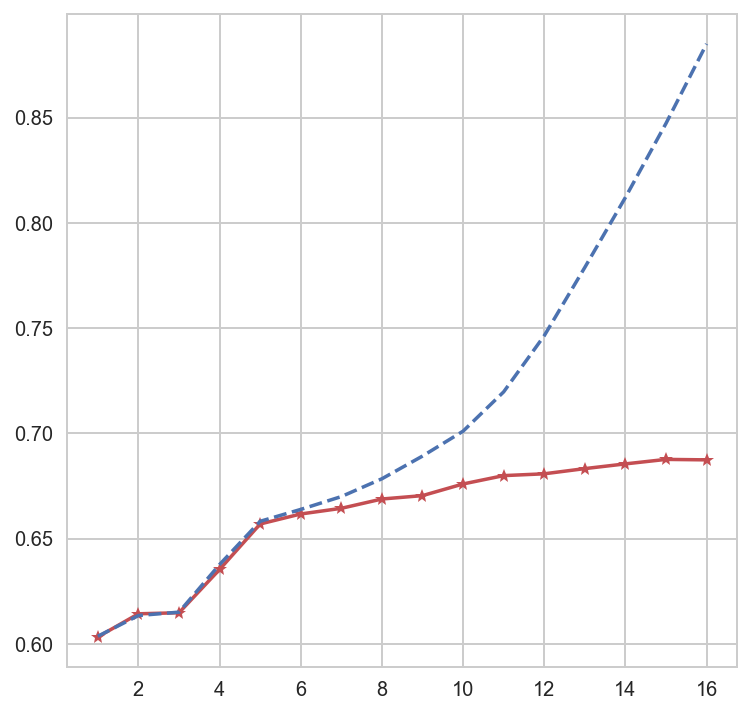

EXmodel creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
model testing...
ExtraTree Model1: Mean score: 0.567 --- acuraccy score : 0.567
ExtraTree Model2: Mean score: 0.612 --- acuraccy score : 0.612
ExtraTree Model3: Mean score: 0.608 --- acuraccy score : 0.608
ExtraTree Model4: Mean score: 0.629 --- acuraccy score : 0.629
ExtraTree Model5: Mean score: 0.634 --- acuraccy score : 0.634
ExtraTree Model6: Mean score: 0.644 --- acuraccy score : 0.647
ExtraTree Model7: Mean score: 0.649 --- acuraccy score : 0.656
ExtraTree Model8: Mean score: 0.658 --- acuraccy score : 0.663
ExtraTree Model9: Mean score: 0.663 --- acuraccy score : 0.676
ExtraTree Model10: Mean score: 0.665 --- acuraccy score : 0.686
ExtraTree Model11: Mean score: 0.669 --- acuraccy score : 0.698
ExtraTree Model12: Mean score: 0.671 --- acuraccy score : 0.717
ExtraTree Model13: Mean score: 0.673 --- acuraccy score : 0.737
ExtraTree Model14: Mean score: 0.676 --- acuraccy score : 0.764
ExtraTree Model15: Mea

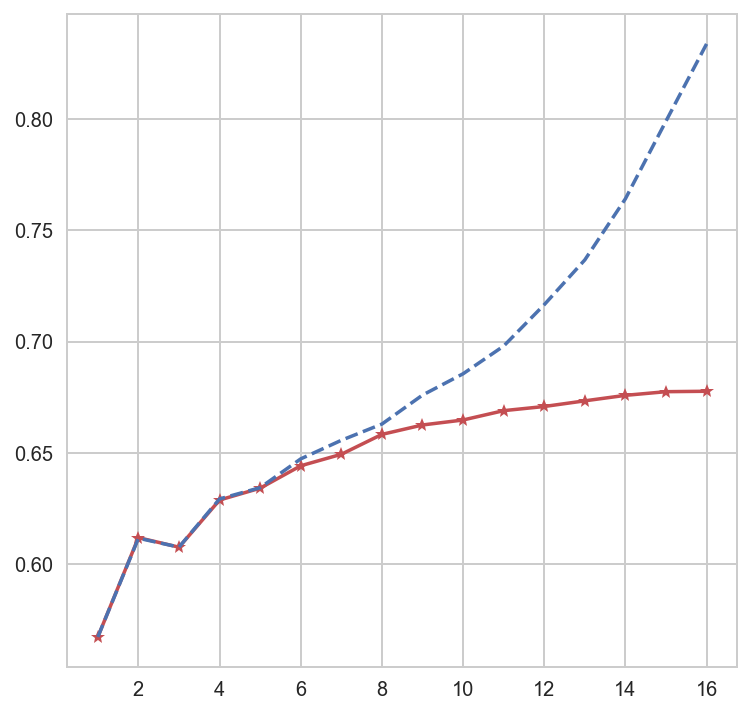

In [103]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
RF_ls = []
score_ls = []
accur_ls = []

# randomforest 모델 자동생성 반복문
print("RFmodel creating..",end="")
for i in range(1,17):
    RF = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=i, random_state=0).fit(df_Ctg,y)
    print(",",i,end="")
    RF_ls.append(RF)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(RF_ls):
    scores = cross_val_score(model, df_Ctg, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_Ctg))
    print(("RandomForest Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#----------------------------------------------------------------------
Ex_ls = []
score_ls = []
accur_ls = []
print("EXmodel creating..",end="")
for i in range(1,17):
    Ex = ExtraTreesClassifier(n_estimators=50, criterion='entropy', max_depth=i, random_state=0).fit(df_Ctg,y)
    print(",",i,end="")
    Ex_ls.append(Ex)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(Ex_ls):
    scores = cross_val_score(model, df_Ctg, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_Ctg))
    print(("ExtraTree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

In [104]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
RF = RandomForestClassifier(n_estimators = 50, criterion='entropy', max_depth=15, random_state=0).fit(df_Ctg,y)

from sklearn.metrics import *
print("- Accuracy_Score : ", accuracy_score(y,RF.predict(df_Ctg)))
print("- Confusion_Matrix \n",confusion_matrix(y, RF.predict(df_Ctg)))
print(classification_report(y, RF.predict(df_Ctg), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))

- Accuracy_Score :  0.812076770549
- Confusion_Matrix 
 [[9823    0    0  716  230]
 [  15  116    0    6   60]
 [ 138    0  846  267  304]
 [1273    0    1 3294  218]
 [1134    0    2  659 7627]]
                 precision    recall  f1-score   support

       Adoption       0.79      0.91      0.85     10769
           Died       1.00      0.59      0.74       197
     Euthanasia       1.00      0.54      0.70      1555
Return_to_owner       0.67      0.69      0.68      4786
       Transfer       0.90      0.81      0.85      9422

    avg / total       0.82      0.81      0.81     26729



array([ 0.08909886,  0.03023982,  0.03229907,  0.18199453,  0.00558674,
        0.02401334,  0.03058347,  0.02510167,  0.06026548,  0.11741257,
        0.0196501 ,  0.0089861 ,  0.        ,  0.00493795,  0.01783566,
        0.00728924,  0.0317283 ,  0.05565924,  0.0596886 ,  0.06863946,
        0.11869784,  0.01029196])

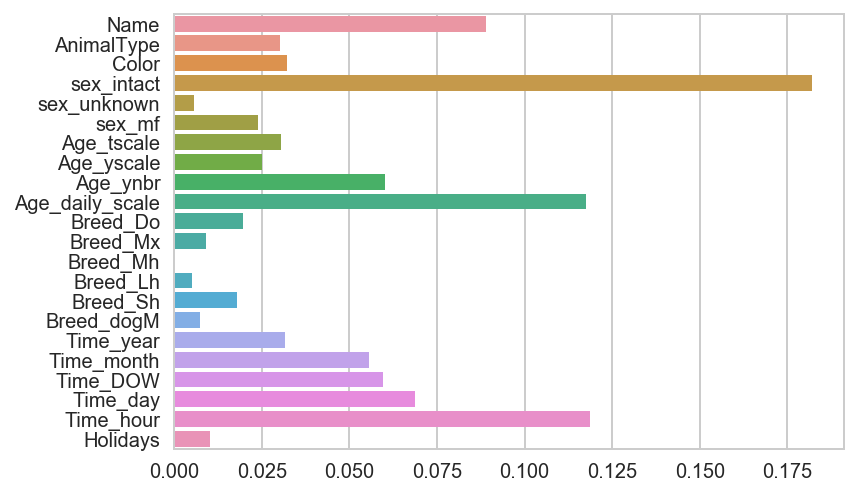

In [106]:
# 피쳐 중요도
importance = RF.feature_importances_
sns.barplot(y=df_Ctg.columns, x=importance)
importance

### XGBoost + cv 

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9
model testing...
XGB Model1: Mean score: 0.585 --- acuraccy score : 0.587
XGB Model2: Mean score: 0.600 --- acuraccy score : 0.602
XGB Model3: Mean score: 0.604 --- acuraccy score : 0.614
XGB Model4: Mean score: 0.606 --- acuraccy score : 0.630
XGB Model5: Mean score: 0.608 --- acuraccy score : 0.655
XGB Model6: Mean score: 0.612 --- acuraccy score : 0.687
XGB Model7: Mean score: 0.610 --- acuraccy score : 0.724
XGB Model8: Mean score: 0.609 --- acuraccy score : 0.775
XGB Model9: Mean score: 0.609 --- acuraccy score : 0.826


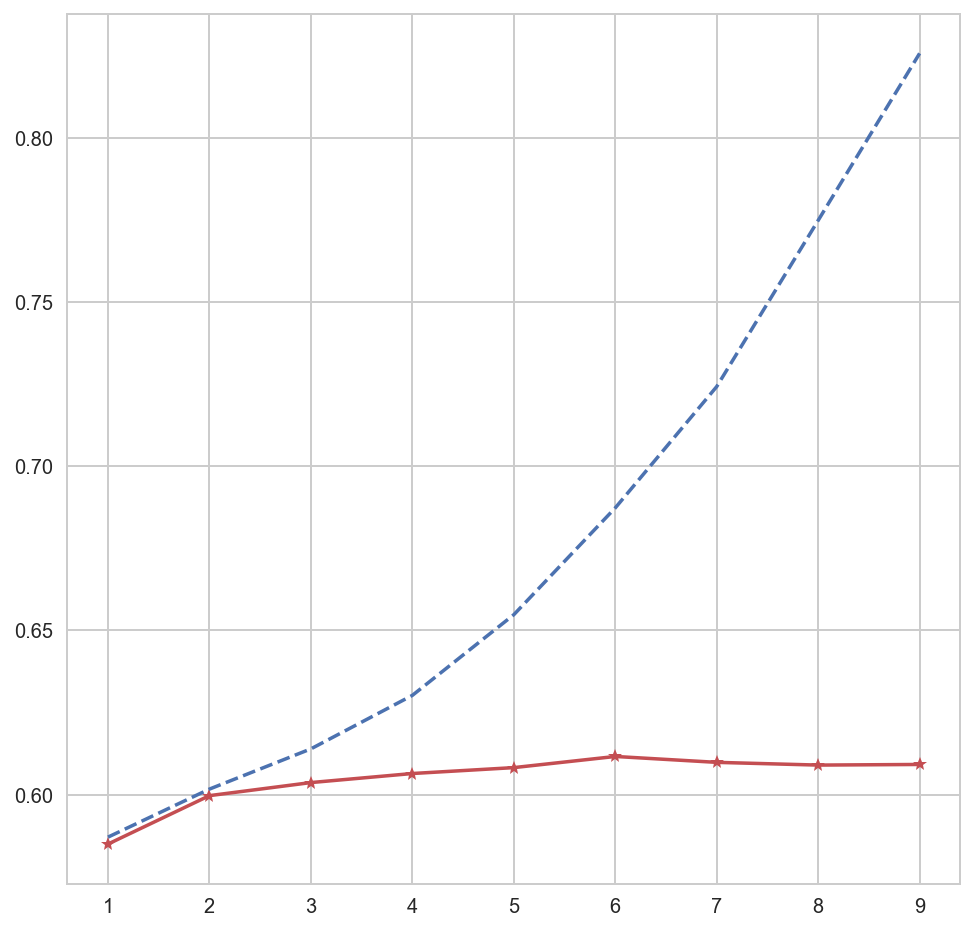

In [42]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost
model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,10):
    XGB = xgboost.XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=i, random_state=0).fit(df_Ctg,y)
    print(",",i,end="")
    model_ls.append(XGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_Ctg, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_Ctg))
    print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

In [107]:
from sklearn.metrics import *

XGB_model = xgboost.XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=14, random_state=0).fit(df_Ctg,y)

scores = cross_val_score(XGB_model, df_Ctg, y,cv=10)
accuracy = accuracy_score(y,XGB_model.predict(df_Ctg))
print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교

print("- Confusion_Matrix \n",confusion_matrix(y, XGB_model.predict(df_Ctg)))
print(classification_report(y, XGB_model.predict(df_Ctg), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))

XGB Model16: Mean score: 0.691 --- acuraccy score : 0.977
- Confusion_Matrix 
 [[10608     0     0   105    56]
 [    7   184     0     3     3]
 [    8     0  1524    14     9]
 [  165     0     0  4590    31]
 [  120     0     1    87  9214]]
                 precision    recall  f1-score   support

       Adoption       0.97      0.99      0.98     10769
           Died       1.00      0.93      0.97       197
     Euthanasia       1.00      0.98      0.99      1555
Return_to_owner       0.96      0.96      0.96      4786
       Transfer       0.99      0.98      0.98      9422

    avg / total       0.98      0.98      0.98     26729



array([  1.17374444e-02,   1.54239107e-02,   7.64020085e-02,
         9.87446308e-03,   0.00000000e+00,   3.69831547e-02,
         8.86068493e-03,   2.63318998e-05,   7.64283389e-02,
         4.18874696e-02,   8.30113143e-03,   1.65035184e-02,
         0.00000000e+00,   4.46325727e-03,   2.36723777e-02,
         1.02365259e-02,   5.63568510e-02,   1.43620774e-01,
         1.09270804e-01,   2.11682141e-01,   1.26636699e-01,
         1.16321174e-02], dtype=float32)

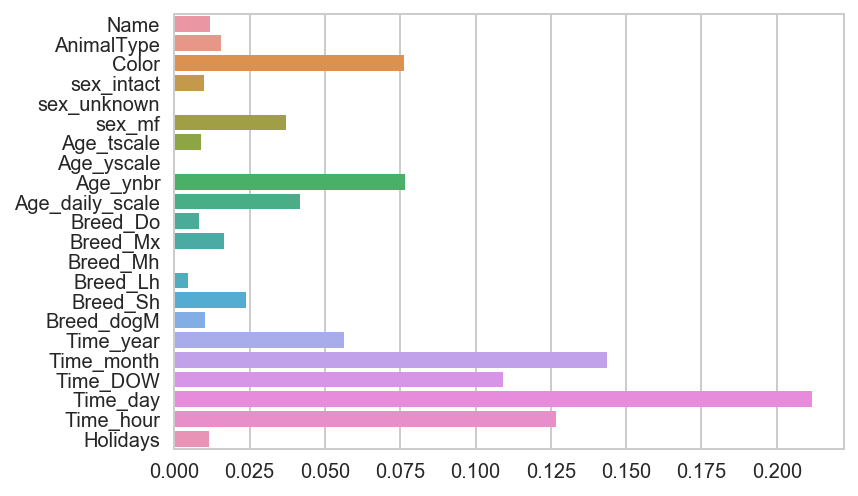

In [108]:
# 피쳐 중요도
importance = XGB_model.feature_importances_
sns.barplot(y=df_Ctg.columns, x=importance)
importance

In [45]:
#Dmatrix
from sklearn.model_selection import cross_val_score, KFold
import xgboost
model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,10):
    XGB_Dm = xgboost.DMatrix(df_Ctg.values,).fit(df_Ctg,y)
    print(",",i,end="")
    model_ls.append(XGB_Dm)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_Ctg, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_Ctg))
    print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

SyntaxError: invalid syntax (<ipython-input-45-b43a29382096>, line 11)

### 앙상블에다가 - 랜덤포레스트 + XGBOOST 

In [235]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost
from sklearn.ensemble import VotingClassifier

model1 = ExtraTreesClassifier(n_estimators=250, criterion="entropy", random_state=0)
model2 = xgboost.XGBClassifier(n_estimators=100, max_depth=5)
ensemble = VotingClassifier(estimators=[('lr', model1),('pda', model2)], voting='soft', weights=[1,2])

In [236]:
model = ensemble.fit(df_X,y)

In [237]:
y_pred = model.predict(df_X)

In [241]:
from sklearn.metrics import *
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']))

[[10087     0     0    30   652]
 [   29     0     0     2   166]
 [  471     0     4   129   951]
 [ 3945     0     2   383   456]
 [ 3192     0     0   279  5951]]
                 precision    recall  f1-score   support

       Adoption       0.57      0.94      0.71     10769
           Died       0.00      0.00      0.00       197
     Euthanasia       0.67      0.00      0.01      1555
Return_to_owner       0.47      0.08      0.14      4786
       Transfer       0.73      0.63      0.68      9422

    avg / total       0.61      0.61      0.55     26729



C:\Users\creal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
np.mean(cross_val_score(model.fit(X,y), X, y, cv=5))

## 7. To improve performace
- AnimalType 별로 나눠서 EDA와 모델 만들어 비교할 예정
- 최적화
- 비대칭 데이터 해결

동물의 처리결과별 - 종 통계


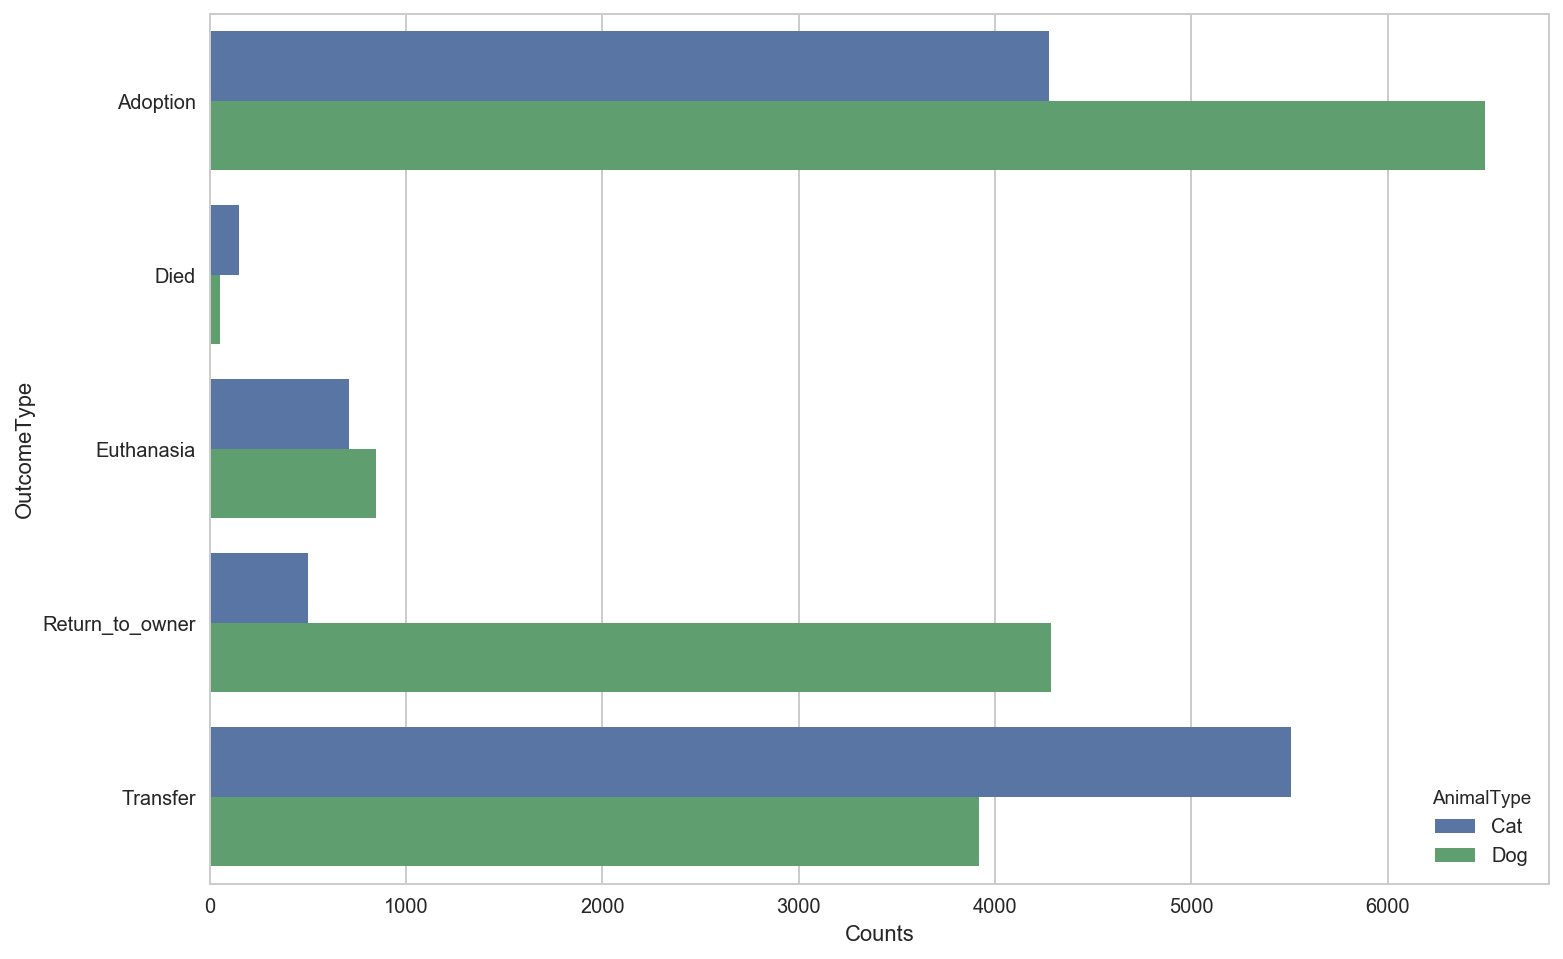

In [84]:
sorted_df = train.groupby(["OutcomeType","AnimalType"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeType", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("동물의 처리결과별 - 종 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

# 캐글점수용 submission 만들기

In [119]:
df_samplesub_animal = pd.read_csv("sample_submission.csv")
test= pd.read_csv("test.csv")

# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
# train["OutcomeSubtype"] = test["OutcomeSubtype"].fillna("NoStatus")
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")

#분석할 컬럼들
cols= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']
cols2=['Name', 'Color', 'Animaltype', 'sex_intact', 'sex_unknown', 'sex_mf',
       'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_daily_scale',
       'Breed_Do', 'Breed_Mx', 'Breed_Mh', 'Breed_Lh', 'Breed_Sh', 'Breed_dogM', 'Breed_extra',
        'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour', 'Holidays']

# 카테고리화 및 OneHotEncoding
df_test = preprocessShelter(test)

# df_OHEt = allOneHotEncoder(df_test,cols2)
# df_Ctgt = allCategorizer(df_test,cols2)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x00000269587BDBA8>>
Traceback (most recent call last):
  File "C:\Users\creal\Anaconda3\lib\site-packages\xgboost\core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is tryin

In [118]:
pred = XGB_model.predict_proba(df_Ctgt)

NameError: name 'df_Ctgt' is not defined

In [116]:
len(pred)

11456